In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [ ]:
base_path = r"c:\Tese\results\time"
dfs = {}

for file in os.listdir(base_path):
    if file.endswith(".csv"):
        path = os.path.join(base_path, file)
        dfs[file] = pd.read_csv(path)

dfs.keys()  

In [ ]:
aes       = dfs["aes_bench_2p10_2p20_per_exec.csv"]
aesgcm    = dfs["aesgcm_bench_2p10_2p20_per_exec.csv"]
chacha    = dfs["chacha20_bench_2p10_2p20_per_exec.csv"]
elgamal   = dfs["elgamal_bench_2p10_2p20_per_exec.csv"]
rsahybrid = dfs["rsa_hybrid_bench_2p10_2p20_per_exec.csv"]

aes["algorithm"]       = "AES"
aesgcm["algorithm"]    = "AES-GCM"
chacha["algorithm"]    = "ChaCha20"
elgamal["algorithm"]   = "ElGamal"
rsahybrid["algorithm"] = "RSA-Hybrid"

data = pd.concat([aes, aesgcm, chacha, elgamal, rsahybrid], ignore_index=True)

data["total_time_ns"] = data["enc_ns"] + data["dec_ns"]

data.head()


,size_bytes,round_index,enc_ns,dec_ns,energy_mWh,algorithm,total_time_ns
0,1024,1,6459200,1713000,0.00853,AES,8172200
1,1024,2,3291300,1452700,0.00853,AES,4744000
2,1024,3,1085000,1405600,0.00853,AES,2490600
3,1024,4,1193500,2622900,0.00853,AES,3816400
4,1024,5,1176200,1593100,0.00853,AES,2769300


In [ ]:
plt.style.use("ggplot")


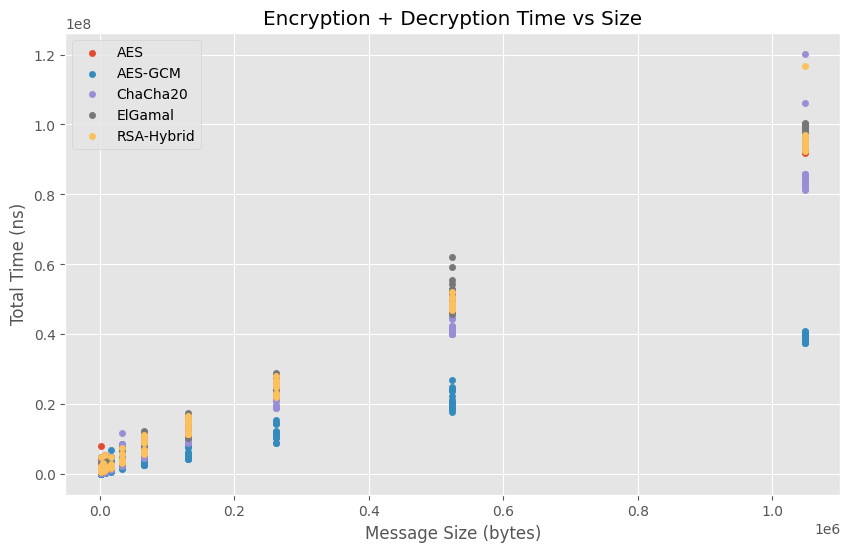

In [14]:
plt.figure(figsize=(10,6))
for alg in data["algorithm"].unique():
    sub = data[data["algorithm"] == alg]
    plt.scatter(sub["size_bytes"], sub["total_time_ns"], s=20, label=alg)

plt.xlabel("Message Size (bytes)")
plt.ylabel("Total Time (ns)")
plt.title("Encryption + Decryption Time vs Size")
plt.legend()
plt.show()


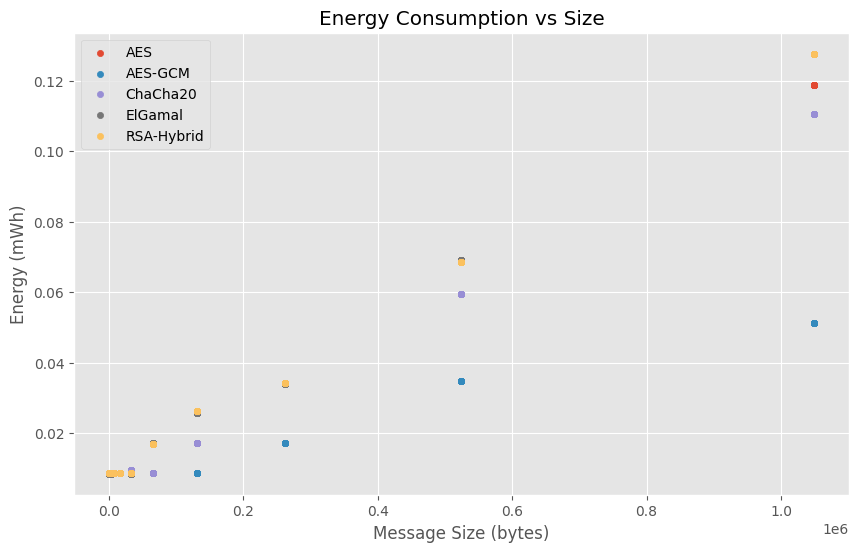

In [15]:
plt.figure(figsize=(10,6))
for alg in data["algorithm"].unique():
    sub = data[data["algorithm"] == alg]
    plt.scatter(sub["size_bytes"], sub["energy_mWh"], s=20, label=alg)

plt.xlabel("Message Size (bytes)")
plt.ylabel("Energy (mWh)")
plt.title("Energy Consumption vs Size")
plt.legend()
plt.show()


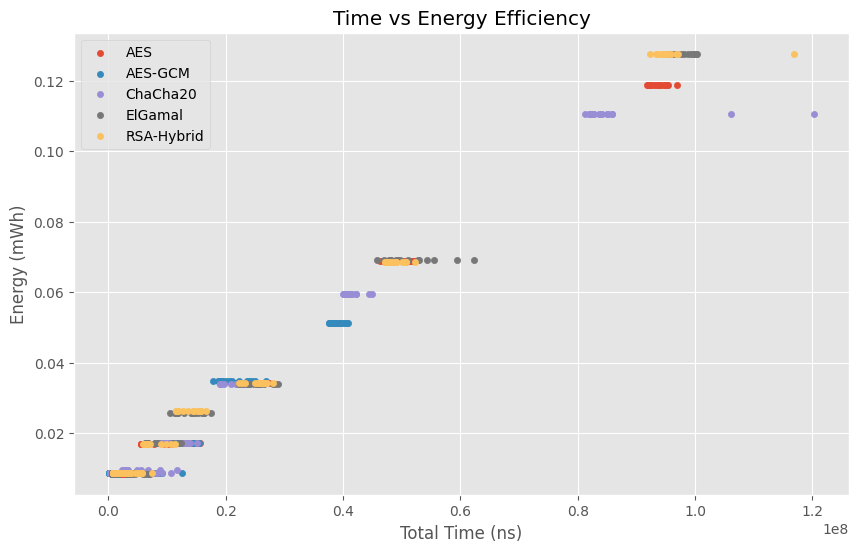

In [16]:
plt.figure(figsize=(10,6))
for alg in data["algorithm"].unique():
    sub = data[data["algorithm"] == alg]
    plt.scatter(sub["total_time_ns"], sub["energy_mWh"], s=20, label=alg)

plt.xlabel("Total Time (ns)")
plt.ylabel("Energy (mWh)")
plt.title("Time vs Energy Efficiency")
plt.legend()
plt.show()


In [ ]:
features = ["size_bytes", "round_index", "algorithm"]
X = data[features]

y_time = data["total_time_ns"]
y_energy = data["energy_mWh"]

X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X, y_time, test_size=0.2)
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X, y_energy, test_size=0.2)

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", ["size_bytes", "round_index"]),
        ("cat", OneHotEncoder(handle_unknown="ignore"), ["algorithm"])
    ]
)

model_time = Pipeline([
    ("prep", preprocess),
    ("rf", RandomForestRegressor(n_estimators=200))
])

model_energy = Pipeline([
    ("prep", preprocess),
    ("rf", RandomForestRegressor(n_estimators=200))
])

model_time.fit(X_train_t, y_train_t)
model_energy.fit(X_train_e, y_train_e)

print("MAE time:", mean_absolute_error(y_test_t, model_time.predict(X_test_t)))
print("MAE energy:", mean_absolute_error(y_test_e, model_energy.predict(X_test_e)))


MAE time: 1314265.3727272728
MAE energy: 3.9727272732414437e-07


In [ ]:

algorithms = ["AES", "AES-GCM", "ChaCha20", "ElGamal", "RSA-Hybrid"]

def recommend_algorithm(size_bytes, alpha=0.5, round_index=1):

    candidates = pd.DataFrame({
        "size_bytes": [size_bytes]*len(algorithms),
        "round_index": [round_index]*len(algorithms),
        "algorithm": algorithms
    })
    
    pred_time   = model_time.predict(candidates)
    pred_energy = model_energy.predict(candidates)
    
    norm_time   = (pred_time - pred_time.min()) / (pred_time.max() - pred_time.min() + 1e-9)
    norm_energy = (pred_energy - pred_energy.min()) / (pred_energy.max() - pred_energy.min() + 1e-9)

    score = alpha * norm_time + (1 - alpha) * norm_energy
    
    candidates["pred_time_ns"]   = pred_time
    candidates["pred_energy_mWh"] = pred_energy
    candidates["score"] = score
    
    return candidates.sort_values("score")


In [21]:
recommend_algorithm(1024, alpha=0.7)



,size_bytes,round_index,algorithm,pred_time_ns,pred_energy_mWh,score
3,1024,1,ElGamal,3289932.0,0.008461,0.159951
4,1024,1,RSA-Hybrid,2281648.0,0.008548,0.299997
2,1024,1,ChaCha20,3378773.0,0.008510,0.343076
1,1024,1,AES-GCM,4108295.0,0.008544,0.576331
0,1024,1,AES,6694238.5,0.008528,0.930531


In [22]:
recommend_algorithm(1024*1024, alpha=0.5)



,size_bytes,round_index,algorithm,pred_time_ns,pred_energy_mWh,score
1,1048576,1,AES-GCM,39323406.0,0.051155,0.000000
2,1048576,1,ChaCha20,84115453.0,0.110555,0.779126
0,1048576,1,AES,94804072.5,0.118906,0.927029
4,1048576,1,RSA-Hybrid,95618760.0,0.127579,0.990768
3,1048576,1,ElGamal,96552196.0,0.127744,1.000000


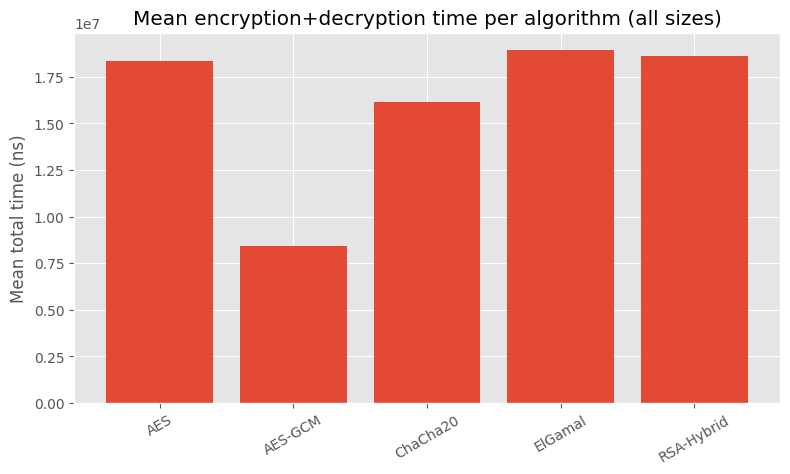

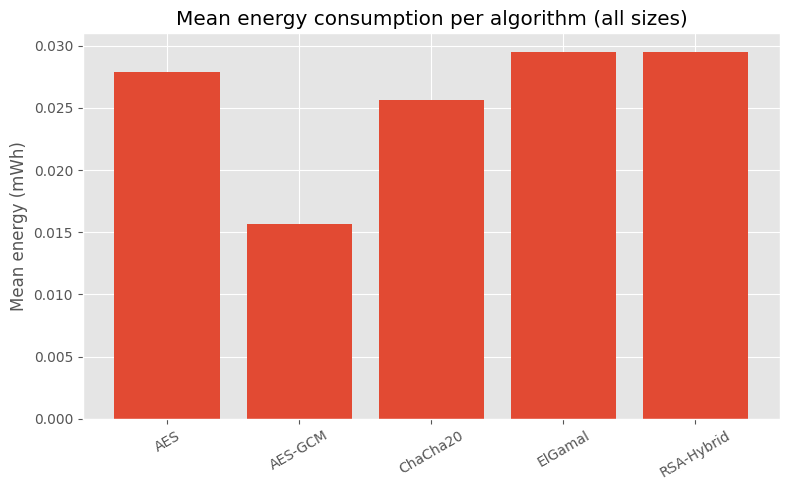

In [ ]:


summary_overall = data.groupby("algorithm").agg(
    mean_time_ns=("total_time_ns","mean"),
    mean_energy_mWh=("energy_mWh","mean")
).reset_index()

plt.figure(figsize=(8,5))
plt.bar(summary_overall["algorithm"], summary_overall["mean_time_ns"])
plt.ylabel("Mean total time (ns)")
plt.title("Mean encryption+decryption time per algorithm (all sizes)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.bar(summary_overall["algorithm"], summary_overall["mean_energy_mWh"])
plt.ylabel("Mean energy (mWh)")
plt.title("Mean energy consumption per algorithm (all sizes)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [ ]:
max_size = data["size_bytes"].max()
max_df = data[data["size_bytes"] == max_size].groupby("algorithm").agg(
    mean_time_ns=("total_time_ns","mean"),
    mean_energy_mWh=("energy_mWh","mean")
).reset_index()

max_df["mean_time_ms"] = max_df["mean_time_ns"] / 1e6

display(max_df[["algorithm","mean_time_ms","mean_energy_mWh"]])


,algorithm,mean_time_ms,mean_energy_mWh
0,AES,93.729460,0.118906
1,AES-GCM,39.047127,0.051155
2,ChaCha20,87.497487,0.110555
3,ElGamal,97.844667,0.127744
4,RSA-Hybrid,96.170740,0.127579


In [25]:
def print_summary_for_report():
    print("=== Overall ranking by mean time (fastest to slowest) ===")
    print(summary_overall.sort_values("mean_time_ns")[["algorithm","mean_time_ns"]])
    print("\n=== Overall ranking by mean energy (lowest to highest) ===")
    print(summary_overall.sort_values("mean_energy_mWh")[["algorithm","mean_energy_mWh"]])

print_summary_for_report()


=== Overall ranking by mean time (fastest to slowest) ===
    algorithm  mean_time_ns
1     AES-GCM  8.393222e+06
2    ChaCha20  1.612817e+07
0         AES  1.836869e+07
4  RSA-Hybrid  1.859173e+07
3     ElGamal  1.893344e+07

=== Overall ranking by mean energy (lowest to highest) ===
    algorithm  mean_energy_mWh
1     AES-GCM         0.015637
2    ChaCha20         0.025613
0         AES         0.027908
4  RSA-Hybrid         0.029517
3     ElGamal         0.029524


## Overall Conclusions

From the combined perspective of **performance**, **energy consumption**, and **security**, the following conclusions can be drawn:

### Best practical choice for bulk data encryption
#### **AES-GCM**
- Provides modern, strong security (**AEAD: authenticated encryption with associated data**)  
- **Fastest algorithm** in all benchmarks  
- **Lowest energy consumption**, making it the most efficient overall  

---

### Good alternative
#### **ChaCha20**
- Cryptographically strong and widely trusted  
- Performance and energy usage are **slightly worse than AES-GCM** in this setup  
- Still an excellent symmetric cipher, especially on hardware without AES acceleration  

---

### Classical asymmetric schemes
#### **RSA-Hybrid and ElGamal**
- **Much slower** and **significantly more energy-intensive**  
- Not suitable for encrypting large amounts of data directly  
- Best used exclusively for:
  - **Key exchange**
  - **Digital signatures**
  - **Encrypting small symmetric keys**, not full messages  

---

### Final Recommendation
Your results experimentally confirm the standard recommendation in modern cryptography:

 **Use symmetric AEAD algorithms like AES-GCM or ChaCha20-Poly1305 for encrypting data, and use asymmetric algorithms only for protecting symmetric keys.**
